In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('axes', fc='w')
rc('figure', fc='w')
rc('savefig', fc='w')
rc('axes', axisbelow=True)

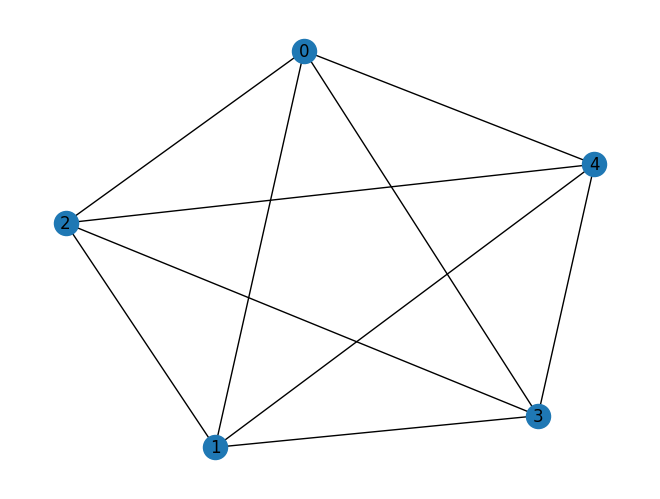

In [2]:
n = 5
G = nx.complete_graph(n)

nx.draw(G, with_labels = True)

plt.savefig('/Users/lpwer/Documents/NetSIPhD/PHYS7332_NetData/HW1/problem2a.png', bbox_inches='tight')

In [ ]:
def degree_preserving_randomization(G, n_iter = 500, fail_max = 200):
    """
    Perform degree-preserving randomization on a graph. 

    This function is modified based on Algorithm 11.1 in Bagrow & Ahn textbook. This version of randomization prevent an infinite loop
    by abandoning the exvhange process after reaching a given number of attempts without a successful exchange. 
    
    Parameters
    ----------
    G : networkx.Graph
        the input graph to be randomized. The graph can be directed or undirected. Must be simple. 

    n_iter : int, optional (default = 1000)
        the number of edge exchange to perform. A higher number of iteration leads to more randomization. 
        In this case, we preserve the degree of nodes. This number should be proportional to the number of edges in the graph
        for sufficient randomization. 

    fail_max : int 
        fail_max is a counter cap that makes sure the exchange process will stop if the infinite loop happens. 

    Returns
    -------
    G_random : networkx.Graph
        A randomized graph with same degree distirbution as the input graph G but with a shuffled edge structure. 

    Notes
    -----
    - This function works by randomly select two independent edges in the network (u, v) and (x, y).
      The attempted exchanges are {(u, x), (v, y)} and {(u, y), (x, v)}.
    - swapped is a flag that checks on whether the edge exchange is successful or not. 
      If swapped is true, then add 1 to the success counter and reset the n_fail counter. 
    - When number of failure reaches the max failure, raise the runtime error and stop the function. 

    Example
    -------
    >>> import networkx as nx
    >>> G = nx.erdos_renyi_graph(10, 0.5)
    >>> G_random = degree_preserving_randomization(G, n_iter=100)

    Citations
    ---------
    Klein, Brennan. PHYS 7332 Fall 2025 Class04 notes
    """
    G_random = G.copy()
    edges = list(G_random.edges())
    num_edge = len(edges)
    n_fail = 0
    success = 0 

    swapped = False

    while n_fail < fail_max and success < n_iter:
        edge1_id = np.random.choice(list(range(num_edge)))
        u, v = edges[edge1_id]
        edge2_id = np.random.choice(list(range(num_edge)))
        x, y = edges[edge2_id]
        
        if len({u, v, x, y}) == 4 and n_fail < fail_max:
            if np.random.rand() > 0.5:
                if not (G_random.has_edge(u, x) or G_random.has_edge(v, y)):
                    G_random.remove_edge(u,v)
                    G_random.remove_edge(x,y)
                    G_random.add_edge(u,x)
                    G_random.add_edge(v,y)
                    swapped = True
                        
            else:
                if not (G_random.has_edge(u, y) or G_random.has_edge(v, x)):
                    G_random.remove_edge(u,v)
                    G_random.remove_edge(x,y)
                    G_random.add_edge(u,y)
                    G_random.add_edge(v,x)
                    swapped = True
        if swapped:
            success += 1
            n_fail = 0
            edges = list(G_random.edges())
        else:
            n_fail += 1

    if n_fail >= fail_max:
        raise RuntimeError(f"Stopped: reached {fail_max} consecutive failed attempts. "
                       "No further swaps possible.")
            
    return G_random

In [ ]:
G = nx.karate_club_graph()
# G = nx.complete_graph(30)
G_random = degree_preserving_randomization(G)
# plot
pos = nx.spring_layout(G)
fig, ax = plt.subplots(1, 2, figsize=(8,4), dpi=200)

nx.draw(G, pos, node_size = 150, node_color='w', edgecolors='.2',
        with_labels=True, font_size='x-small', ax = ax[0])
ax[0].set_title('Original graph')

nx.draw(G_random, pos, node_size = 150, node_color='w', edgecolors='.2',
        with_labels=True, font_size='x-small', ax = ax[1])
ax[1].set_title('Randomized graph')


In [ ]:
import numpy as np
import networkx as nx

def degree_preserving_randomization(
    G,
    n_iter=500,
    fail_max=200,
    connectivity='auto',        # 'auto' | 'undirected' | 'weak' | 'strong' | None
    preserve_partition=False,    # if True, preserve exact component membership (costlier)
    seed=None
):
    """
    Degree-preserving edge-swap randomization with optional connectivity preservation.

    Parameters
    ----------
    G : nx.Graph or nx.DiGraph
        Simple graph (no multiedges), directed or undirected.

    n_iter : int
        Target number of successful swaps.

    fail_max : int
        Max consecutive failed attempts before aborting.

    connectivity : {'auto','undirected','weak','strong', None}
        If 'undirected': preserve connectivity (nx.is_connected) for Graph.
        If 'weak':       preserve weak connectivity (one weak component) for DiGraph.
        If 'strong':     preserve strong connectivity (one strongly-connected component).
        If 'auto':       'undirected' for Graph, 'weak' for DiGraph.
        If None:         do not enforce connectivity (classic double-edge swap).

    preserve_partition : bool
        If True, preserve the exact component partition of the original graph
        (same nodes stay in same component labels). This is stricter and slower.
        For most null models, preserving connectedness (single component) is enough.

    seed : int or None
        RNG seed for reproducibility.

    Returns
    -------
    G_random : nx.Graph or nx.DiGraph
        Degree-preserving randomized graph that respects the chosen connectivity constraint.

    Notes
    -----
    - Uses two-edge swaps on pairs of independent edges (u->v) and (x->y):
        option A: (u->y) and (x->v)
        option B: (u->x) and (v->y)     (for DiGraph, directions matter)
    - Rejects swaps that would introduce parallel edges or self-loops.
    - With connectivity constraints, many swaps get rejected; consider raising n_iter
      and/or fail_max, or run multiple passes.

    Raises
    ------
    RuntimeError if fail_max consecutive attempts fail.
    """
    rng = np.random.default_rng(seed)
    G_random = G.copy()
    is_directed = G_random.is_directed()

    # Resolve connectivity mode
    if connectivity == 'auto':
        connectivity = 'weak' if is_directed else 'undirected'

    # Capture the original connectivity “baseline”
    if connectivity is None:
        baseline = None
    else:
        if not is_directed and connectivity != 'undirected':
            raise ValueError("Undirected graphs must use connectivity='undirected' or None.")
        if is_directed and connectivity == 'undirected':
            raise ValueError("Use 'weak' or 'strong' for directed graphs, or None.")

        if not is_directed:  # Graph
            baseline = {
                'connected': nx.is_connected(G_random),
            }
            if preserve_partition:
                comp_map = {}
                for cid, comp in enumerate(nx.connected_components(G_random)):
                    for n in comp:
                        comp_map[n] = cid
                baseline['comp_map'] = comp_map

        else:  # DiGraph
            if connectivity == 'weak':
                comps = list(nx.weakly_connected_components(G_random))
                baseline = {'n_comps': len(comps)}
                if preserve_partition:
                    comp_map = {}
                    for cid, comp in enumerate(comps):
                        for n in comp:
                            comp_map[n] = cid
                    baseline['comp_map'] = comp_map
            elif connectivity == 'strong':
                comps = list(nx.strongly_connected_components(G_random))
                baseline = {'n_comps': len(comps)}
                if preserve_partition:
                    comp_map = {}
                    for cid, comp in enumerate(comps):
                        for n in comp:
                            comp_map[n] = cid
                    baseline['comp_map'] = comp_map
            else:
                raise ValueError("connectivity must be 'weak', 'strong', 'undirected', 'auto', or None.")

    def connectivity_ok(H):
        """Check connectivity constraint relative to baseline."""
        if connectivity is None:
            return True

        if not is_directed:
            if baseline['connected']:
                if not nx.is_connected(H):
                    return False
                if preserve_partition:
                    # Re-label current components and compare node->component map
                    curr_map = {}
                    for cid, comp in enumerate(nx.connected_components(H)):
                        for n in comp:
                            curr_map[n] = cid
                    # Components are unlabeled; compare partition sets by signature:
                    # build {node: orig_label} and {node: new_label}, then ensure
                    # for all u,v, (orig[u]==orig[v]) iff (curr[u]==curr[v]).
                    # Faster: compare frozenset of frozensets:
                    def part_signature(map_):
                        inv = {}
                        for n,lbl in map_.items():
                            inv.setdefault(lbl,set()).add(n)
                        return frozenset(frozenset(s) for s in inv.values())
                    return part_signature(baseline['comp_map']) == part_signature(curr_map)
                return True
            else:
                # Multi-component case: preserve partition or at least component count
                curr = list(nx.connected_components(H))
                if preserve_partition:
                    curr_map = {}
                    for cid, comp in enumerate(curr):
                        for n in comp:
                            curr_map[n] = cid
                    def part_signature(map_):
                        inv = {}
                        for n,lbl in map_.items():
                            inv.setdefault(lbl,set()).add(n)
                        return frozenset(frozenset(s) for s in inv.values())
                    return part_signature(baseline['comp_map']) == part_signature(curr_map)
                else:
                    return len(curr) == len(list(nx.connected_components(G_random)))

        else:
            if connectivity == 'weak':
                curr = list(nx.weakly_connected_components(H))
            else:
                curr = list(nx.strongly_connected_components(H))

            if preserve_partition:
                curr_map = {}
                for cid, comp in enumerate(curr):
                    for n in comp:
                        curr_map[n] = cid
                def part_signature(map_):
                    inv = {}
                    for n,lbl in map_.items():
                        inv.setdefault(lbl,set()).add(n)
                    return frozenset(frozenset(s) for s in inv.values())
                return part_signature(baseline['comp_map']) == part_signature(curr_map)
            else:
                return len(curr) == baseline['n_comps']

    # Main swap loop
    edges = list(G_random.edges())
    m = len(edges)
    if m < 2:
        return G_random

    n_fail = 0
    success = 0

    while n_fail < fail_max and success < n_iter:
        swapped = False  # reset each attempt

        # Sample two distinct edges uniformly at random
        e1_idx = rng.integers(0, m)
        e2_idx = rng.integers(0, m - 1)
        if e2_idx >= e1_idx:
            e2_idx += 1
        (u, v) = edges[e1_idx]
        (x, y) = edges[e2_idx]

        # Require four distinct nodes (avoids self-loops)
        if len({u, v, x, y}) != 4:
            n_fail += 1
            continue

        # Two possible rewires:
        # Option A: (u, v) + (x, y) -> (u, y) + (x, v)
        # Option B: (u, v) + (x, y) -> (u, x) + (v, y)
        # For undirected graphs, directions are ignored by NetworkX API.
        candidates = []
        if not (G_random.has_edge(u, y) or G_random.has_edge(x, v)):
            candidates.append(((u, v), (x, y), (u, y), (x, v)))
        if not (G_random.has_edge(u, x) or G_random.has_edge(v, y)):
            candidates.append(((u, v), (x, y), (u, x), (v, y)))

        if not candidates:
            n_fail += 1
            continue

        # Randomly choose one candidate rewire
        (e1_old, e2_old, e1_new, e2_new) = candidates[rng.integers(0, len(candidates))]

        # Try the swap
        G_random.remove_edge(*e1_old)
        G_random.remove_edge(*e2_old)
        G_random.add_edge(*e1_new)
        G_random.add_edge(*e2_new)

        if connectivity_ok(G_random):
            swapped = True
        else:
            # Revert the swap
            G_random.remove_edge(*e1_new)
            G_random.remove_edge(*e2_new)
            G_random.add_edge(*e1_old)
            G_random.add_edge(*e2_old)
            swapped = False

        if swapped:
            success += 1
            n_fail = 0
            edges = list(G_random.edges())
            m = len(edges)
        else:
            n_fail += 1

    if n_fail >= fail_max:
        raise RuntimeError(
            f"Stopped: reached {fail_max} consecutive failed attempts. "
            "No further swaps possible under the connectivity constraint."
        )

    return G_random


In [ ]:
G = nx.karate_club_graph()
# G = nx.complete_graph(30)
G_random = degree_preserving_randomization(G)
# plot
pos = nx.spring_layout(G)
fig, ax = plt.subplots(1, 2, figsize=(8,4), dpi=200)

nx.draw(G, pos, node_size = 150, node_color='w', edgecolors='.2',
        with_labels=True, font_size='x-small', ax = ax[0])
ax[0].set_title('Original graph')

nx.draw(G_random, pos, node_size = 150, node_color='w', edgecolors='.2',
        with_labels=True, font_size='x-small', ax = ax[1])
ax[1].set_title('Randomized graph')


In [ ]:
import numpy as np
import networkx as nx
from collections import Counter

def degree_preserving_randomization_preserve_xcorr(
    G,
    x_attr="x",            # node attribute name OR a dict {node: -1 or 1}
    n_iter=500,
    fail_max=200,
    seed=None,
    ordered=None           # if None: directed -> ordered, undirected -> unordered
):
    """
    Degree-preserving edge-swap randomization that ALSO preserves the
    correlation on edges of a binary node attribute x ∈ {-1, 1}.
    
    Constraint: For any two edges (u,v) and (x,y) chosen for rewiring,
    the multiset of edge types {(x_u, x_v), (x_x, x_y)} must be conserved
    after rewiring. For directed graphs, types are ordered pairs; for
    undirected graphs, types are unordered pairs.

    Parameters
    ----------
    G : nx.Graph or nx.DiGraph
    x_attr : str or dict
        If str, read node attribute G.nodes[n][x_attr] ∈ {-1,1}.
        If dict, mapping {node: -1 or 1}.
    n_iter : int
        Target number of successful swaps.
    fail_max : int
        Abort after this many consecutive failed attempts.
    seed : int or None
        RNG seed.
    ordered : bool or None
        Treat edge types as ordered pairs (True) or unordered pairs (False).
        Default: directed -> True; undirected -> False.

    Returns
    -------
    G_random : same type as G
    """
    rng = np.random.default_rng(seed)
    H = G.copy()
    is_dir = H.is_directed()
    if ordered is None:
        ordered = is_dir

    # Build x map
    if isinstance(x_attr, dict):
        x = x_attr
    else:
        x = {n: H.nodes[n][x_attr] for n in H.nodes()}
    # Validate binary {-1,1}
    for n, val in x.items():
        if val not in (-1, 1):
            raise ValueError(f"Node {n} has x={val}; expected -1 or 1.")

    def etype(a, b):
        """Edge type given node attributes."""
        xa, xb = x[a], x[b]
        if ordered:
            return (xa, xb)
        else:
            # unordered pair for undirected graphs
            return tuple(sorted((xa, xb)))

    def same_type_multiset(types_old, types_new):
        """Conserve multiset of two edge types."""
        return Counter(types_old) == Counter(types_new)

    edges = list(H.edges())
    m = len(edges)
    if m < 2:
        return H

    n_fail = 0
    success = 0

    while n_fail < fail_max and success < n_iter:
        swapped = False

        # sample two distinct edges
        i = rng.integers(0, m)
        j = rng.integers(0, m - 1)
        if j >= i: j += 1
        (u, v) = edges[i]
        (a, b) = edges[j]

        # four distinct nodes to avoid self-loops
        if len({u, v, a, b}) != 4:
            n_fail += 1
            continue

        # old types
        T1 = etype(u, v)
        T2 = etype(a, b)

        # candidate rewires (standard two-edge swap)
        cand = []
        # Option A: (u,b) and (a,v)
        if not (H.has_edge(u, b) or H.has_edge(a, v)):
            T1n, T2n = etype(u, b), etype(a, v)
            if same_type_multiset([T1, T2], [T1n, T2n]):
                cand.append(((u, v), (a, b), (u, b), (a, v)))
        # Option B: (u,a) and (v,b)
        if not (H.has_edge(u, a) or H.has_edge(v, b)):
            T1n, T2n = etype(u, a), etype(v, b)
            if same_type_multiset([T1, T2], [T1n, T2n]):
                cand.append(((u, v), (a, b), (u, a), (v, b)))

        if not cand:
            n_fail += 1
            continue

        # try one candidate
        (e1_old, e2_old, e1_new, e2_new) = cand[rng.integers(0, len(cand))]
        H.remove_edge(*e1_old)
        H.remove_edge(*e2_old)
        H.add_edge(*e1_new)
        H.add_edge(*e2_new)

        swapped = True  # type, degree, and simplicity constraints already checked

        if swapped:
            success += 1
            n_fail = 0
            edges = list(H.edges())
            m = len(edges)
        else:
            n_fail += 1

    if n_fail >= fail_max:
        raise RuntimeError(
            f"Stopped after {fail_max} consecutive failed attempts; "
            "type-preserving swaps too constrained."
        )

    return H
